<a href="https://colab.research.google.com/github/Gr-30/DL/blob/main/Assign4_Q2_Twitter_114_final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# 1. Import Libraries/Dataset

## a. Import the required libraries and the dataset.

In [42]:
import os
seed=21
os.environ['PYTHONHASHSEED']=str(seed)
import copy
import time
import numpy as np 
import pandas as pd 
import seaborn as sns 
import matplotlib.pyplot as plt
plt.style.use('ggplot')
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
from sklearn.model_selection import train_test_split
from mlxtend.plotting import plot_confusion_matrix
import matplotlib.cm as cm
from matplotlib import rcParams
from collections import Counter
import tensorflow.keras.regularizers as reg
import tensorflow as tf
from tensorflow.keras.layers import LSTM, Activation, Dense, Dropout, Input, Embedding
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import RMSprop, Adam
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing import sequence
import tensorflow_hub as hub
embed = hub.load("https://tfhub.dev/google/nnlm-en-dim128/2")
%matplotlib inline
from wordcloud import WordCloud, STOPWORDS
import warnings
warnings.filterwarnings("ignore")

def reset_random_seeds(seed_val):
    os.environ['PYTHONHASHSEED']=str(seed_val)
    tf.random.set_seed(seed_val)
    np.random.seed(seed_val)

reset_random_seeds(seed)

## b. Check the GPU available

In [3]:
!nvidia-smi -L

GPU 0: Tesla T4 (UUID: GPU-778ca916-2346-7ec0-6f00-2e46c5e7d9c6)


# Data Visualization

In [4]:
data = pd.read_csv("/content/drive/MyDrive/Mtech DSE BITS/Sem3/DL/Assignment1/training.1600000.processed.noemoticon.csv", encoding = "ISO-8859-1", engine="python", header=None)
 # As the data has no column titles, we will add our own
data.columns = ["label", "time", "date", "query", "username", "text"]

## a. Print at least two movie reviews from each class of the dataset, for a sanity check that labels match the text.

In [78]:
df_pos = data[data['label'] == 1]
df_neg = data[data['label'] == 0]

In [79]:
print('POSITIVE Label data ')
df_pos.head()

POSITIVE Label data 


,text,label
800000,I LOVE @Health4UandPets u guys r the best!!,1
800001,im meeting up with one of my besties tonight! ...,1
800002,"@DaRealSunisaKim Thanks for the Twitter add, S...",1
800003,Being sick can be really cheap when it hurts t...,1
800004,@LovesBrooklyn2 he has that effect on everyone,1


In [80]:
print('Negative Label data ')
df_neg.head()

Negative Label data 


,text,label
0,"@switchfoot http://twitpic.com/2y1zl - Awww, t...",0
1,is upset that he can't update his Facebook by ...,0
2,@Kenichan I dived many times for the ball. Man...,0
3,my whole body feels itchy and like its on fire,0
4,"@nationwideclass no, it's not behaving at all....",0


#### Five top records of data

In [10]:
data.head()

,label,time,date,query,username,text
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."


#### Five last records of data

In [11]:
data.tail()

,label,time,date,query,username,text
1599995,4,2193601966,Tue Jun 16 08:40:49 PDT 2009,NO_QUERY,AmandaMarie1028,Just woke up. Having no school is the best fee...
1599996,4,2193601969,Tue Jun 16 08:40:49 PDT 2009,NO_QUERY,TheWDBoards,TheWDB.com - Very cool to hear old Walt interv...
1599997,4,2193601991,Tue Jun 16 08:40:49 PDT 2009,NO_QUERY,bpbabe,Are you ready for your MoJo Makeover? Ask me f...
1599998,4,2193602064,Tue Jun 16 08:40:49 PDT 2009,NO_QUERY,tinydiamondz,Happy 38th Birthday to my boo of alll time!!! ...
1599999,4,2193602129,Tue Jun 16 08:40:50 PDT 2009,NO_QUERY,RyanTrevMorris,happy #charitytuesday @theNSPCC @SparksCharity...


#### Coloumns/features in data

In [12]:
data.columns

Index(['label', 'time', 'date', 'query', 'username', 'text'], dtype='object')

In [13]:
data['label'].value_counts()

4    800000
0    800000
Name: label, dtype: int64

#### Length of data

In [14]:
print('lenght of data is', len(data))

lenght of data is 1600000


#### Shape of data

In [15]:
data.shape

(1600000, 6)

#### Data information

In [16]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1600000 entries, 0 to 1599999
Data columns (total 6 columns):
 #   Column    Non-Null Count    Dtype 
---  ------    --------------    ----- 
 0   label     1600000 non-null  int64 
 1   time      1600000 non-null  int64 
 2   date      1600000 non-null  object
 3   query     1600000 non-null  object
 4   username  1600000 non-null  object
 5   text      1600000 non-null  object
dtypes: int64(2), object(4)
memory usage: 73.2+ MB


#### Data types of all coloumns

In [17]:
data.dtypes

label        int64
time         int64
date        object
query       object
username    object
text        object
dtype: object

#### Checking Null values

In [18]:
np.sum(data.isnull().any(axis=1))

0

#### Rows and columns in the dataset

In [19]:
print('Count of columns in the data is:  ', len(data.columns))

Count of columns in the data is:   6


In [20]:
print('Count of rows in the data is:  ', len(data))

Count of rows in the data is:   1600000


In [21]:
data=data[['text','label']]

## b. Plot a bar graph of class distribution in a dataset. Each bar depicts the number of tweets belonging to a particular sentiment.

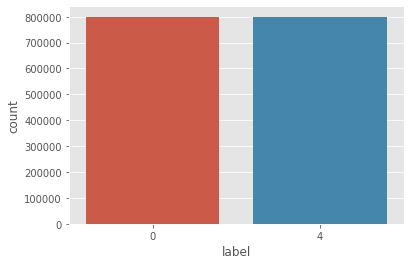

In [22]:
datag = data.groupby('label').size().reset_index(name='count')
sns.barplot(y="count",x="label", data=datag)


## c. Other visualizations

In [23]:
stopwords_ = set(STOPWORDS)

def show_wordcloud(data, title = None):
    wordcloud = WordCloud(
        collocations=False,
        background_color='white',
        stopwords=stopwords_,
        max_words=200,
        max_font_size=40, 
        scale=3,
        random_state=1
    ).generate(str(data))

    fig = plt.figure(1, figsize=(12, 12))
    plt.axis('off')
    if title: 
        fig.suptitle(title, fontsize=20)
        fig.subplots_adjust(top=2.3)

    plt.imshow(wordcloud)
    plt.show()

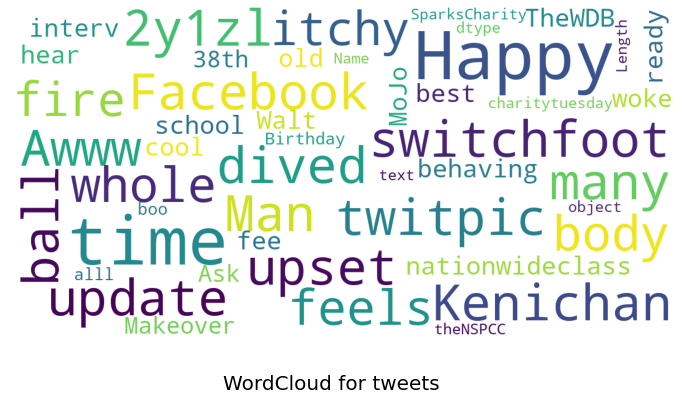

In [24]:
show_wordcloud(data['text'], "WordCloud for tweets")

## Assigning 1 to Positive sentment 4

In [25]:
data['label'][data['label']==4]=1

##  Separating input feature and label

In [28]:
X=data.text
y=data.label

#### Preparing the input features for training 

#### Separating the 70% data for training data and 30% for testing data

As we prepared all the tweets, now we are separating/splitting the tweets into training data and testing data.
- 70% tweets will be used in the training 
- 20% tweets will be used to test the performance of the model.

In [29]:
X_train_org, X_test_org, Y_train, Y_test = train_test_split(data, y, test_size=0.2, random_state=2)

# Data Pre-processing
a. Need for this Step-Since the models we use cannot accept string inputs or cannot be of the string format. We have to come up with a way of handling this step. The discussion of different ways of handling this step is out of the scope of this assignment.

b. Please use this pre-trained embedding layerfrom TensorFlow hub for this assignment. This link also has a code snippet on how to convert a sentence to a vector. Refer to that for further clarity on this subject.

c. Bring the train and test data in the required format.

In [30]:
X_train = embed(X_train_org.text.values).numpy()
X_test = embed(X_test_org.text.values).numpy()

# Data Visualization

## d. Print the shapes of train and test data.

In [31]:
print('X_train: ', X_train.shape)
print('X_test: ', X_test.shape)
print('Y_train: ', Y_train.shape)
print('Y_test: ', Y_test.shape)

X_train:  (1280000, 128)
X_test:  (320000, 128)
Y_train:  (1280000,)
Y_test:  (320000,)


# Model Building
a. Sequential Model layers-Use AT LEAST 3 hidden layers with appropriate input for each. Choose the best number for hidden units and give reasons.

b. Add L2 regularization to all the layers.

c. Add one layer of dropout at the appropriate position and give reasons.d.Choose the appropriate activation function for all the layers.e.Print the model summary.

In [32]:
def model_base(): #Defined tensorflow_based_model function for training tenforflow based model
    inputs = Input(name='inputs',shape=(128))
    layer = Dropout(0.1, name='dropout')(inputs)
    layer = Dense(64,name='layer1', activation='relu',kernel_regularizer=reg.L2(0.0005))(inputs)
    layer = Dense(32,name='layer2', activation='relu', kernel_regularizer=reg.L2(0.0005))(layer) 
    layer = Dense(16,name='layer3', activation='relu', kernel_regularizer=reg.L2(0.0005))(layer) 
    layer = Dense(1,name='output', activation='sigmoid')(layer) 
    model = Model(inputs=inputs,outputs=layer) #here we are getting the final output value in the model for classification
    return model #function returning the value when we call it

callback = EarlyStopping(monitor='val_loss', min_delta=0.001, patience=3, verbose=1,mode='auto', baseline=None, restore_best_weights=False
)

## e. Print the model summary

In [81]:
model = model_base() # here we are calling the function of created model
print('Model summary')
model.summary() 

Model summary
Model: "model_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inputs (InputLayer)          [(None, 128)]             0         
_________________________________________________________________
layer1 (Dense)               (None, 64)                8256      
_________________________________________________________________
layer2 (Dense)               (None, 32)                2080      
_________________________________________________________________
layer3 (Dense)               (None, 16)                528       
_________________________________________________________________
output (Dense)               (None, 1)                 17        
Total params: 10,881
Trainable params: 10,881
Non-trainable params: 0
_________________________________________________________________


# Model Compilation
a.Compile the model with the appropriate loss function.

b.Use an appropriate optimizer. Give reasons for the choice of learning rate and its value.: **We intially choose 0.001(least possible) but later realised that the training is too slow and could be improved without compromising the accuracy of the model so changed the learning rate to 0.005.**

c.Use accuracy as a metric.

In [33]:
model.compile(loss='binary_crossentropy',optimizer=RMSprop(learning_rate=0.005),metrics=['accuracy']) 

Model summary
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inputs (InputLayer)          [(None, 128)]             0         
_________________________________________________________________
layer1 (Dense)               (None, 64)                8256      
_________________________________________________________________
layer2 (Dense)               (None, 32)                2080      
_________________________________________________________________
layer3 (Dense)               (None, 16)                528       
_________________________________________________________________
output (Dense)               (None, 1)                 17        
Total params: 10,881
Trainable params: 10,881
Non-trainable params: 0
_________________________________________________________________


# Model Training
a. Train the model for an appropriate number of epochs. Print the train and validation accuracy and loss for each epoch. Use the appropriate batch size.

b. Plot the loss and accuracy history graphs for both train and validation set. Print the total time taken for training.

In [34]:
startTime = time.time()
history=model.fit(X_train,Y_train,batch_size=128,epochs=100, validation_split=0.2, callbacks=[callback])# here we are starting the training of model by feeding the training data
endTime = time.time()
print('Training finished in : {}s'.format(round(endTime - startTime, 2)))

Epoch 1/100
8000/8000 [==============================] - 23s 2ms/step - loss: 0.5890 - accuracy: 0.7012 - val_loss: 0.5736 - val_accuracy: 0.7112
Epoch 2/100
8000/8000 [==============================] - 20s 2ms/step - loss: 0.5740 - accuracy: 0.7106 - val_loss: 0.5888 - val_accuracy: 0.6963
Epoch 3/100
8000/8000 [==============================] - 20s 2ms/step - loss: 0.5736 - accuracy: 0.7108 - val_loss: 0.5732 - val_accuracy: 0.7110
Epoch 4/100
8000/8000 [==============================] - 19s 2ms/step - loss: 0.5728 - accuracy: 0.7115 - val_loss: 0.5714 - val_accuracy: 0.7118
Epoch 5/100
8000/8000 [==============================] - 19s 2ms/step - loss: 0.5739 - accuracy: 0.7098 - val_loss: 0.5721 - val_accuracy: 0.7124
Epoch 6/100
8000/8000 [==============================] - 19s 2ms/step - loss: 0.5734 - accuracy: 0.7109 - val_loss: 0.5709 - val_accuracy: 0.7130
Epoch 7/100
8000/8000 [==============================] - 19s 2ms/step - loss: 0.5730 - accuracy: 0.7104 - val_loss: 0.5740 -

Text(0.5, 0, 'epoch')

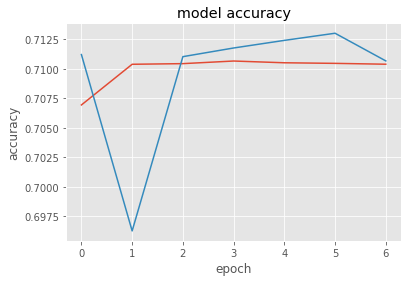

In [35]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')

{'loss': [0.5795378088951111, 0.5740906000137329, 0.5736697316169739, 0.5734640955924988, 0.5733491778373718, 0.5734882950782776, 0.5732192993164062], 'accuracy': [0.7069453001022339, 0.7103935480117798, 0.7104472517967224, 0.7106689214706421, 0.7105205059051514, 0.7104706764221191, 0.7103984355926514], 'val_loss': [0.5735945701599121, 0.5887560844421387, 0.5732113718986511, 0.5713712573051453, 0.5721309185028076, 0.5709047317504883, 0.5740077495574951], 'val_accuracy': [0.7112148404121399, 0.6962695121765137, 0.7110390663146973, 0.7117734551429749, 0.7124179601669312, 0.7130234241485596, 0.7106797099113464]}


Text(0.5, 0, 'epoch')

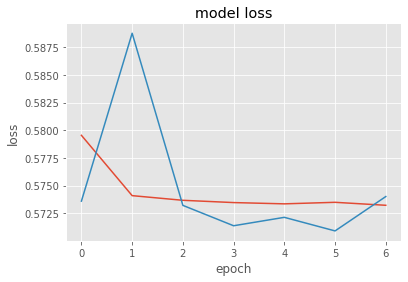

In [36]:
print(history.history)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')

# Model Evaluation

a.Print the final train and validation loss and accuracy. Print confusion matrix and classification report for the validation dataset. Analyse and report the best and worst performing class.

b.Print the two most incorrectly classified texts for each class in the test dataset.

### Testing the Trained model on test data
- Getting predictions/classifying the sentiments (positve/negative) on the test data using trained model.

In [37]:
accr1 = model.evaluate(X_test,Y_test) #we are starting to test the model here

10000/10000 [==============================] - 17s 2ms/step - loss: 0.5733 - accuracy: 0.7114


In [38]:
print('Test set\n  Accuracy: {:0.2f}'.format(accr1[1])) #the accuracy of the model on test data is given below

Test set
  Accuracy: 0.71


In [39]:
y_pred = model.predict(X_test) #getting predictions on the trained model
y_pred_class = (y_pred > 0.5)

confusion matrix
[[121372  38669]
 [ 53689 106270]]


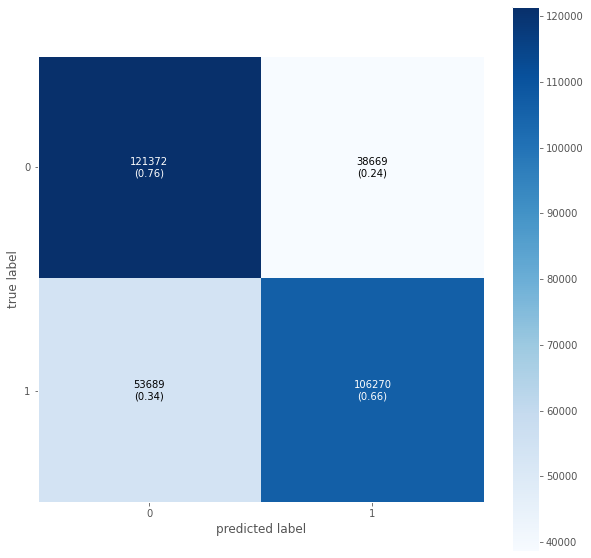

In [40]:
print("confusion matrix")
CR=confusion_matrix(Y_test, y_pred_class)
print(CR)
fig, ax = plot_confusion_matrix(conf_mat=CR,figsize=(10, 10),
                                show_absolute=True,
                                show_normed=True,
                                colorbar=True)
plt.show()

Negative class or Negative Sentiment is slightly better performing as per the confusion matrix.

### ROC CURVE

In [43]:
print(roc_auc_score(Y_test, y_pred_class))

0.7113692033129544


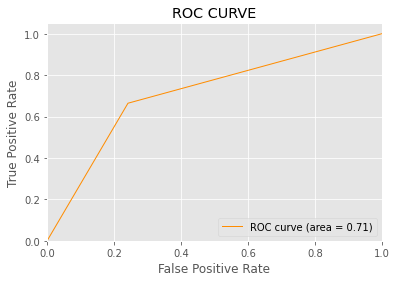

In [44]:
fpr, tpr, thresholds = roc_curve(Y_test, y_pred_class)
roc_auc = auc(fpr, tpr)
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=1, label='ROC curve (area = %0.2f)' % roc_auc)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC CURVE')
plt.legend(loc="lower right")
plt.show()
print()

### b.Print the two most incorrectly classified texts for each class in the test dataset.

In [47]:
def find_2_smallest_index(arr):
    first = 999
    second = 999
    first_index=0
    sexond_index=0
    for i in range(len(arr)):
        if arr[i] < first:
            second = copy.deepcopy(first)
            second_index = copy.deepcopy(first_index)
            first = copy.deepcopy(arr[i])
            first_index = copy.deepcopy(i)
        elif (arr[i] < second):
            second = copy.deepcopy(arr[i])
            second_index = copy.deepcopy(i)
    return first_index, second_index

In [49]:
worst_2 = {}
first_index, second_index = find_2_smallest_index(1-y_pred[:])
worst_2[0] = [X_test_org.text.values[first_index],X_test_org.text.values[second_index]]
first_index, second_index = find_2_smallest_index(y_pred[:])
worst_2[1] = [X_test_org.text.values[first_index],X_test_org.text.values[second_index]]
worst_2

{0: ['#BTS is fallin!!   #BTS #BTS #BTS #BTS #BTS #BTS #BTS #BTS #BTS #BTS #BTS #BTS #BTS #BTS #BTS #BTS #BTS #BTS #BTS #BTS #BTS #BTS #BTS',
  'great day, great weather, great place, great movie, great food, great people '],
 1: ['bad bad bad bad bad bad bad bad bad bad bad bad bad bad bad bad bad bad bad day. ',
  'headache headache headache ']}

In [52]:
def model_hyp1(): #Defined tensorflow_based_model function for training tenforflow based model
    inputs = Input(name='inputs',shape=(128))
    layer = Dropout(0.1, name='dropout')(inputs)
    layer = Dense(64,name='layer1', activation='relu',kernel_regularizer=reg.L2(0.0005))(inputs)
    layer = Dense(32,name='layer2', activation='relu', kernel_regularizer=reg.L2(0.0005))(layer) 
    layer = Dense(16,name='layer3', activation='relu', kernel_regularizer=reg.L2(0.0005))(layer) 
    layer = Dense(8,name='layer4', activation='relu', kernel_regularizer=reg.L2(0.0005))(layer)
    layer = Dense(1,name='output', activation='sigmoid')(layer) 
    model = Model(inputs=inputs,outputs=layer) #here we are getting the final output value in the model for classification
    return model #function returning the value when we call it

callback = EarlyStopping(monitor='val_loss', min_delta=0.001, patience=3, verbose=1,mode='auto', baseline=None, restore_best_weights=False
)

# Model compilation

In [53]:
model = model_hyp1() # here we are calling the function of created model
model.compile(loss='binary_crossentropy',optimizer=RMSprop(learning_rate=0.005),metrics=['accuracy']) 
print('Model summary')
model.summary() 

Model summary
Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inputs (InputLayer)          [(None, 128)]             0         
_________________________________________________________________
layer1 (Dense)               (None, 64)                8256      
_________________________________________________________________
layer2 (Dense)               (None, 32)                2080      
_________________________________________________________________
layer3 (Dense)               (None, 16)                528       
_________________________________________________________________
layer4 (Dense)               (None, 8)                 136       
_________________________________________________________________
output (Dense)               (None, 1)                 9         
Total params: 11,009
Trainable params: 11,009
Non-trainable params: 0
_________________________________________

In [54]:
startTime = time.time()
history=model.fit(X_train,Y_train,batch_size=128,epochs=100, validation_split=0.2, callbacks=[callback])# here we are starting the training of model by feeding the training data
endTime = time.time()
print('Training finished in : {}s'.format(round(endTime - startTime, 2)))

Epoch 1/100
8000/8000 [==============================] - 22s 3ms/step - loss: 0.5922 - accuracy: 0.7003 - val_loss: 0.5746 - val_accuracy: 0.7107
Epoch 2/100
8000/8000 [==============================] - 21s 3ms/step - loss: 0.5758 - accuracy: 0.7092 - val_loss: 0.5911 - val_accuracy: 0.6925
Epoch 3/100
8000/8000 [==============================] - 21s 3ms/step - loss: 0.5751 - accuracy: 0.7102 - val_loss: 0.5722 - val_accuracy: 0.7121
Epoch 4/100
8000/8000 [==============================] - 21s 3ms/step - loss: 0.5740 - accuracy: 0.7106 - val_loss: 0.5717 - val_accuracy: 0.7118
Epoch 5/100
8000/8000 [==============================] - 21s 3ms/step - loss: 0.5748 - accuracy: 0.7093 - val_loss: 0.5723 - val_accuracy: 0.7122
Epoch 6/100
8000/8000 [==============================] - 21s 3ms/step - loss: 0.5741 - accuracy: 0.7102 - val_loss: 0.5711 - val_accuracy: 0.7129
Epoch 7/100
8000/8000 [==============================] - 21s 3ms/step - loss: 0.5738 - accuracy: 0.7099 - val_loss: 0.5740 -

Text(0.5, 0, 'epoch')

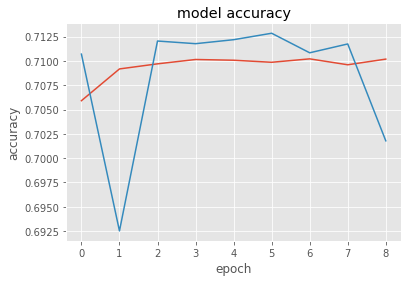

In [55]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')

Text(0.5, 0, 'epoch')

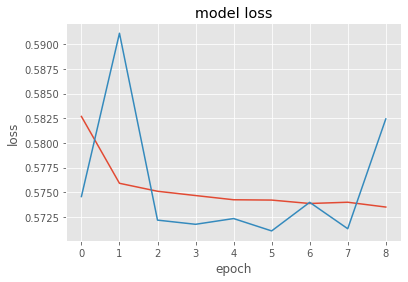

In [56]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')

#### Testing the Trained model on test data
- Getting predictions/classifying the sentiments (positve/negative) on the test data using trained model.

In [57]:
accr1 = model.evaluate(X_test,Y_test) #we are starting to test the model here

10000/10000 [==============================] - 18s 2ms/step - loss: 0.5821 - accuracy: 0.7034


In [58]:
print('Test set\n  Accuracy: {:0.2f}'.format(accr1[1])) #the accuracy of the model on test data is given below

Test set
  Accuracy: 0.70


In [59]:
y_pred = model.predict(X_test) #getting predictions on the trained model
y_pred = (y_pred > 0.5)



confusion matrix


[[130007  30034]
 [ 64886  95073]]




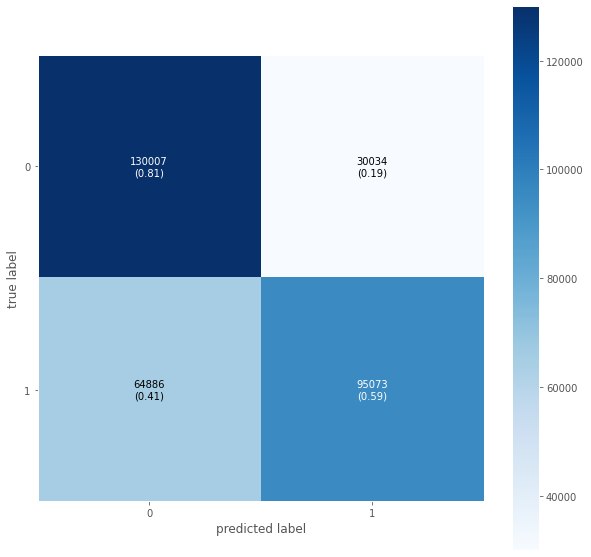

In [60]:
print('\n')
print("confusion matrix")
print('\n')
CR=confusion_matrix(Y_test, y_pred)
print(CR)
print('\n')

fig, ax = plot_confusion_matrix(conf_mat=CR,figsize=(10, 10),
                                show_absolute=True,
                                show_normed=True,
                                colorbar=True)
plt.show()

# ROC CURVE

In [61]:
print(roc_auc_score(Y_test, y_pred))

0.7033470716924386


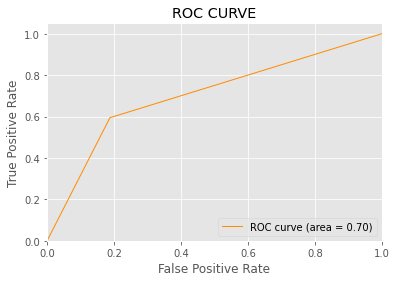

In [62]:
fpr, tpr, thresholds = roc_curve(Y_test, y_pred)
roc_auc = auc(fpr, tpr)
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=1, label='ROC curve (area = %0.2f)' % roc_auc)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC CURVE')
plt.legend(loc="lower right")
plt.show()
print()

In [ ]:
worst_2 = {}
first_index, second_index = find_2_smallest_index(1-y_pred[:])
worst_2[0] = [X_test_org.text.values[first_index],X_test_org.text.values[second_index]]
first_index, second_index = find_2_smallest_index(y_pred[:])
worst_2[1] = [X_test_org.text.values[first_index],X_test_org.text.values[second_index]]
worst_2

{0: ['Painted Black-Rolling Stones..the best!  ',
  "kk, i'm logging off now  BYEZZ!"],
 1: ['@brodiejay OH IM GOING THERE! Wow Mona Vale is a real place afterall! I know it sucks Mville only does the slow train pffft ',
  "my baby's growing up "]}

### 2. Optimiser: Use a different optimizer with the appropriate LR value

In [63]:
def model_hyp2(): #Defined tensorflow_based_model function for training tenforflow based model
    inputs = Input(name='inputs',shape=(128))
    layer = Dropout(0.1, name='dropout')(inputs)
    layer = Dense(64,name='layer1', activation='relu',kernel_regularizer=reg.L2(0.0005))(inputs)
    layer = Dense(32,name='layer2', activation='relu', kernel_regularizer=reg.L2(0.0005))(layer) 
    layer = Dense(16,name='layer3', activation='relu', kernel_regularizer=reg.L2(0.0005))(layer) 
    layer = Dense(1,name='output', activation='sigmoid')(layer) 
    model = Model(inputs=inputs,outputs=layer) #here we are getting the final output value in the model for classification
    return model #function returning the value when we call it

callback = EarlyStopping(monitor='val_loss', min_delta=0.001, patience=3, verbose=1,mode='auto', baseline=None, restore_best_weights=False
)

In [64]:
model = model_hyp2() # here we are calling the function of created model
model.compile(loss='binary_crossentropy',optimizer=Adam(learning_rate=0.005),metrics=['accuracy']) 
print('Model summary')
model.summary() 

Model summary
Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inputs (InputLayer)          [(None, 128)]             0         
_________________________________________________________________
layer1 (Dense)               (None, 64)                8256      
_________________________________________________________________
layer2 (Dense)               (None, 32)                2080      
_________________________________________________________________
layer3 (Dense)               (None, 16)                528       
_________________________________________________________________
output (Dense)               (None, 1)                 17        
Total params: 10,881
Trainable params: 10,881
Non-trainable params: 0
_________________________________________________________________


In [65]:
startTime = time.time()
history=model.fit(X_train,Y_train,batch_size=128,epochs=100, validation_split=0.2, callbacks=[callback])# here we are starting the training of model by feeding the training data
endTime = time.time()
print('Training finished in : {}s'.format(round(endTime - startTime, 2)))

Epoch 1/100
8000/8000 [==============================] - 18s 2ms/step - loss: 0.5887 - accuracy: 0.7022 - val_loss: 0.5732 - val_accuracy: 0.7109
Epoch 2/100
8000/8000 [==============================] - 17s 2ms/step - loss: 0.5721 - accuracy: 0.7113 - val_loss: 0.5694 - val_accuracy: 0.7118
Epoch 3/100
8000/8000 [==============================] - 17s 2ms/step - loss: 0.5710 - accuracy: 0.7113 - val_loss: 0.5737 - val_accuracy: 0.7078
Epoch 4/100
8000/8000 [==============================] - 17s 2ms/step - loss: 0.5704 - accuracy: 0.7117 - val_loss: 0.5731 - val_accuracy: 0.7092
Epoch 5/100
8000/8000 [==============================] - 17s 2ms/step - loss: 0.5715 - accuracy: 0.7098 - val_loss: 0.5685 - val_accuracy: 0.7126
Epoch 00005: early stopping
Training finished in : 87.3s


Text(0.5, 0, 'epoch')

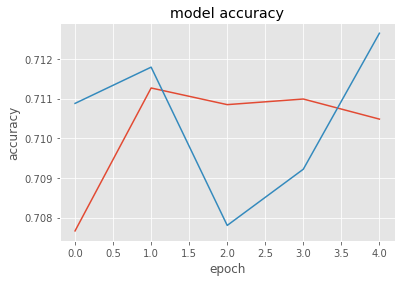

In [66]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')

{'loss': [0.5796305537223816, 0.5718625783920288, 0.5710631608963013, 0.5708610415458679, 0.5707933306694031], 'accuracy': [0.7076621055603027, 0.7112675905227661, 0.7108476758003235, 0.710989236831665, 0.7104824185371399], 'val_loss': [0.5731704235076904, 0.5693957805633545, 0.573668897151947, 0.5731199383735657, 0.5684860944747925], 'val_accuracy': [0.7108789086341858, 0.7117929458618164, 0.7078008055686951, 0.7092187404632568, 0.7126484513282776]}


Text(0.5, 0, 'epoch')

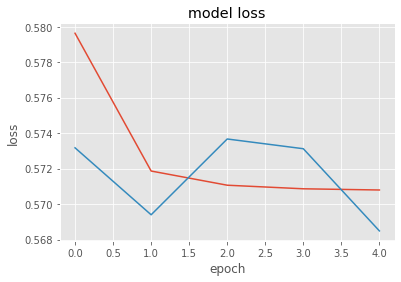

In [67]:
print(history.history)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')

#### Testing the Trained model on test data
- Getting predictions/classifying the sentiments (positve/negative) on the test data using trained model.

In [68]:
accr1 = model.evaluate(X_test,Y_test) #we are starting to test the model here

10000/10000 [==============================] - 17s 2ms/step - loss: 0.5674 - accuracy: 0.7137


In [69]:
print('Test set\n  Accuracy: {:0.2f}'.format(accr1[1])) #the accuracy of the model on test data is given below

Test set
  Accuracy: 0.71


In [70]:
y_pred = model.predict(X_test) #getting predictions on the trained model
y_pred = (y_pred > 0.5)



confusion matrix


[[115198  44843]
 [ 46786 113173]]




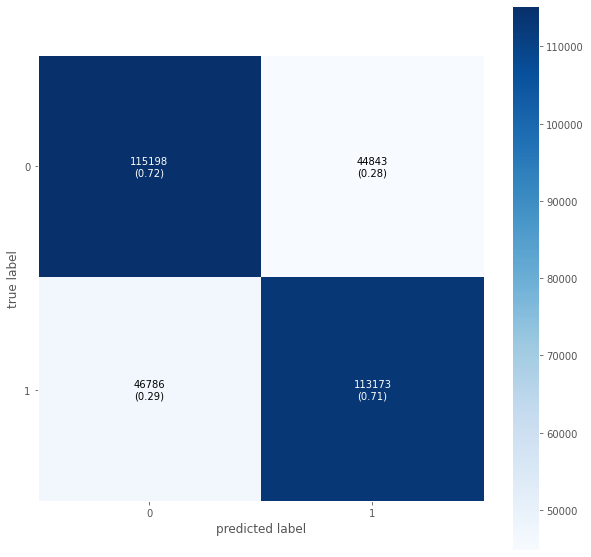

In [71]:
print('\n')
print("confusion matrix")
print('\n')
CR=confusion_matrix(Y_test, y_pred)
print(CR)
print('\n')

fig, ax = plot_confusion_matrix(conf_mat=CR,figsize=(10, 10),
                                show_absolute=True,
                                show_normed=True,
                                colorbar=True)
plt.show()

# ROC CURVE

In [72]:
print(roc_auc_score(Y_test, y_pred))

0.7136578002796391


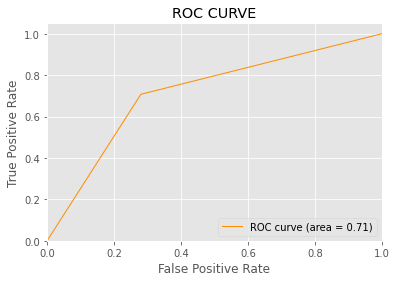

In [73]:
fpr, tpr, thresholds = roc_curve(Y_test, y_pred)
roc_auc = auc(fpr, tpr)
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=1, label='ROC curve (area = %0.2f)' % roc_auc)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC CURVE')
plt.legend(loc="lower right")
plt.show()
print()

In [77]:
worst_2 = {}
first_index, second_index = find_2_smallest_index(1-y_pred[:])
worst_2[0] = [X_test_org.text.values[first_index],X_test_org.text.values[second_index]]
first_index, second_index = find_2_smallest_index(y_pred[:])
worst_2[1] = [X_test_org.text.values[first_index],X_test_org.text.values[second_index]]
worst_2

{0: ['Painted Black-Rolling Stones..the best!  ',
  "kk, i'm logging off now  BYEZZ!"],
 1: ['@brodiejay OH IM GOING THERE! Wow Mona Vale is a real place afterall! I know it sucks Mville only does the slow train pffft ',
  "my baby's growing up "]}

## Preparing the input features for training 

## Separating the 70% data for training data and 30% for testing data

As we prepared all the tweets, now we are separating/splitting the tweets into training data and testing data.
- 70% tweets will be used in the training 
- 30% tweets will be used to test the performance of the model.

## Model Building
a. Sequential Model layers-Use AT LEAST 3 hidden layers with appropriate input for each. Choose the best number for hidden units and give reasons.

b. Add L2 regularization to all the layers.

c. Add one layer of dropout at the appropriate position and give reasons.d.Choose the appropriate activation function for all the layers.e.Print the model summary.

# Model compilation

a.Compile the model with the appropriate loss function.

b.Use an appropriate optimizer. Give reasons for the choice of learning rate and its value.

c.Use accuracy as a metric.

# Model Training
a.Compile the model with the appropriate loss function.

b.Use an appropriate optimizer. Give reasons for the choice of learning rate and its value.

c.Use accuracy as a metric.

# Model Evaluation

a.Print the final train and validation loss and accuracy. Print confusion matrix and classification report for the validation dataset. Analyse and report the best and worst performing class.

b.Print the two most incorrectly classified texts for each class in the test dataset.

### Testing the Trained model on test data
- Getting predictions/classifying the sentiments (positve/negative) on the test data using trained model.

Negative class or Negative Sentiment is slightly better performing as per the confusion matrix.

### ROC CURVE

# Hyperparameter Tuning

Build two more models by changing the following hyperparameters one at a time. Write the code for Model Building, Model Compilation, Model Training and Model Evaluation as given in the instructions above for each additional model.